In [ ]:
!pip install onnx
!pip install onnxruntime

In [ ]:
import numpy as np
import onnx
import onnxruntime
from onnx import numpy_helper
import urllib.request
import json
import time
import os
import glob

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [ ]:
onnx_model_url = "https://s3.amazonaws.com/onnx-model-zoo/vgg/vgg16/vgg16.tar.gz"
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Truy xuất mô hình từ model zoo
urllib.request.urlretrieve(onnx_model_url, filename = "vgg16-12.tar.gz")
urllib.request.urlretrieve(imagenet_labels_url, filename="imagenet-simple-labels.json")

!tar xvzf vgg16-12.tar.gz --warning=no-unknown-keyword

./._vgg16
vgg16/
vgg16/._test_data_set_0
vgg16/test_data_set_0/
vgg16/._test_data_set_1
vgg16/test_data_set_1/
vgg16/._test_data_set_2
vgg16/test_data_set_2/
vgg16/._vgg16.onnx
vgg16/vgg16.onnx
vgg16/test_data_set_2/._input_0.pb
vgg16/test_data_set_2/input_0.pb
vgg16/test_data_set_2/._output_0.pb
vgg16/test_data_set_2/output_0.pb
vgg16/test_data_set_1/._input_0.pb
vgg16/test_data_set_1/input_0.pb
vgg16/test_data_set_1/._output_0.pb
vgg16/test_data_set_1/output_0.pb
vgg16/test_data_set_0/._input_0.pb
vgg16/test_data_set_0/input_0.pb
vgg16/test_data_set_0/._output_0.pb
vgg16/test_data_set_0/output_0.pb


### Load sample inputs and outputs

In [ ]:
test_data_dir = '/content/vgg16/test_data_set_0'

# load input
inputs = []
inputs_num = len(glob.glob(os.path.join(test_data_dir, 'input_*.pb')))
for i in range(inputs_num):
    input_file = os.path.join(test_data_dir, 'input_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(input_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    inputs.append(numpy_helper.to_array(tensor))

# load output
outputs = []
outputs_num = len(glob.glob(os.path.join(test_data_dir, 'input_*.pb')))
for i in range(inputs_num):
    output_file = os.path.join(test_data_dir, 'input_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(output_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    outputs.append(numpy_helper.to_array(tensor))

### Inference using ONNX Time

In [ ]:
# run model on the backend
model = onnxruntime.InferenceSession('/content/vgg16/vgg16.onnx', None)

# get the bame of the first input of the model
input_name = model.get_inputs()[0].name
input_name

'data'

In [ ]:
outputs = [model.run([], {input_name: inputs[i]})[0] for i in range(inputs_num)]

### Phân loại 
- input của vgg16 là 224, 224

In [ ]:
def preprocess(input_data):
    # convert the input data into the float 32 input
    img_data =input_data.astype('float32')

    # normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    std_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i, :, :] = (img_data[i, :, :]/255 - mean_vec[i]) / std_vec[i]
    
    # add bacth channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

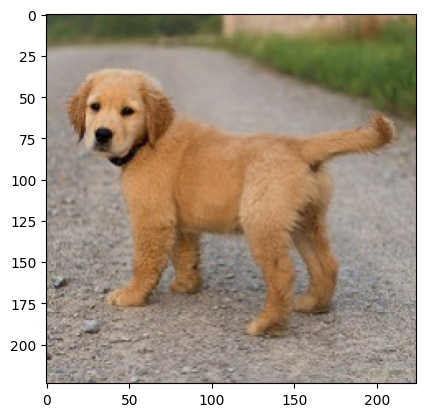

In [ ]:
image = Image.open('/content/dog.jpg')
image = image.resize((224, 224))
plt.imshow(image)
image_data = np.array(image).transpose(2, 0, 1)
input_data = preprocess(image_data)

In [ ]:
start = time.time()
raw_result = model.run([], {input_name: input_data})
end = time.time()
res = postprocess(raw_result)

Final top predict: Golden Retriever
Time: 800.98 ms


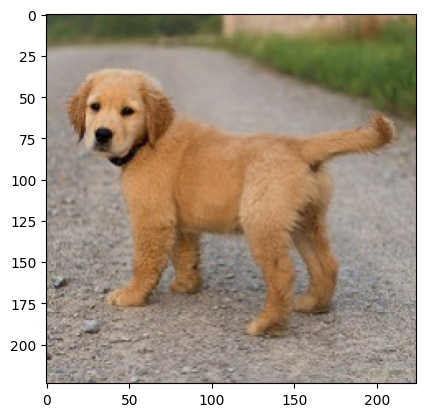

In [ ]:
inference_time = np.round((end-start) * 1000, 2)
idx = np.argmax(res)

print('Final top predict: ' + labels[idx])
print('Time: ' + str(inference_time)+ ' ms')
plt.imshow(image)

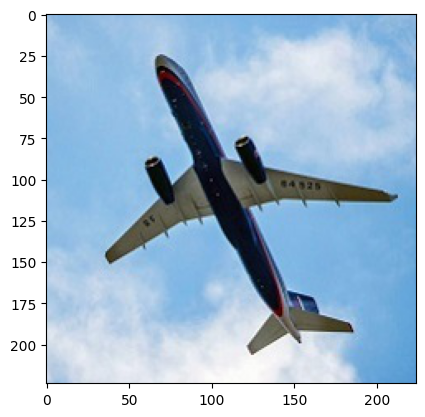

In [ ]:
image1 = Image.open('/content/plane.jpg')
image1 = image1.resize((224, 224))
image_data1 = np.array(image1).transpose(2, 0, 1)
input_data1 = preprocess(image_data1)
plt.imshow(image1)

In [ ]:
start = time.time()
raw_result = model.run([], {input_name: input_data1})
end = time.time()
res = postprocess(raw_result)

Final top predict: airliner
Time: 498.32 ms


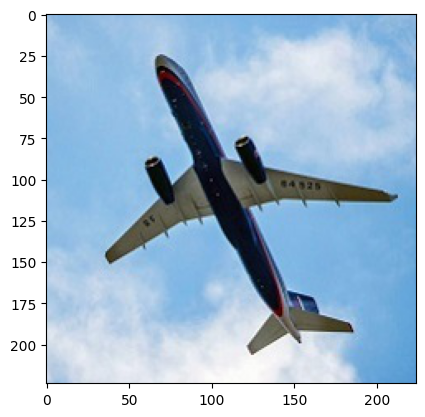

In [ ]:
inference_time = np.round((end-start) * 1000, 2)
idx = np.argmax(res)

print('Final top predict: ' + labels[idx])
print('Time: ' + str(inference_time)+ ' ms')
plt.imshow(image1)

In [2]:
#@title
labels = ["tench","goldfish","great white shark","tiger shark","hammerhead shark","electric ray","stingray","cock","hen","ostrich","brambling","goldfinch",
"house finch","junco","indigo bunting","American robin","bulbul","jay","magpie","chickadee","American dipper","kite","bald eagle","vulture","great grey owl","fire salamander","smooth newt","newt",
"spotted salamander","axolotl","American bullfrog","tree frog","tailed frog","loggerhead sea turtle","leatherback sea turtle","mud turtle","terrapin","box turtle","banded gecko","green iguana",
"Carolina anole","desert grassland whiptail lizard","agama","frilled-necked lizard","alligator lizard","Gila monster","European green lizard","chameleon","Komodo dragon","Nile crocodile",
"American alligator","triceratops","worm snake","ring-necked snake","eastern hog-nosed snake","smooth green snake","kingsnake","garter snake","water snake","vine snake",
"night snake","boa constrictor","African rock python","Indian cobra","green mamba","sea snake","Saharan horned viper","eastern diamondback rattlesnake","sidewinder","trilobite","harvestman",
"scorpion","yellow garden spider","barn spider","European garden spider","southern black widow","tarantula","wolf spider","tick","centipede","black grouse","ptarmigan","ruffed grouse",
"prairie grouse","peacock","quail","partridge","grey parrot","macaw","sulphur-crested cockatoo","lorikeet","coucal","bee eater","hornbill","hummingbird","jacamar","toucan","duck",
"red-breasted merganser","goose","black swan","tusker","echidna","platypus","wallaby","koala","wombat","jellyfish","sea anemone","brain coral","flatworm","nematode","conch","snail","slug",
"sea slug","chiton","chambered nautilus","Dungeness crab","rock crab","fiddler crab","red king crab","American lobster","spiny lobster",
"crayfish",
"hermit crab",
"isopod",
"white stork",
"black stork",
"spoonbill",
"flamingo",
"little blue heron",
"great egret",
"bittern",
"crane (bird)",
"limpkin",
"common gallinule",
"American coot",
"bustard",
"ruddy turnstone",
"dunlin",
"common redshank",
"dowitcher",
"oystercatcher",
"pelican",
"king penguin",
"albatross",
"grey whale",
"killer whale",
"dugong",
"sea lion",
"Chihuahua",
"Japanese Chin",
"Maltese",
"Pekingese",
"Shih Tzu",
"King Charles Spaniel",
"Papillon",
"toy terrier",
"Rhodesian Ridgeback",
"Afghan Hound",
"Basset Hound",
"Beagle",
"Bloodhound",
"Bluetick Coonhound",
"Black and Tan Coonhound",
"Treeing Walker Coonhound",
"English foxhound",
"Redbone Coonhound",
"borzoi",
"Irish Wolfhound",
"Italian Greyhound",
"Whippet",
"Ibizan Hound",
"Norwegian Elkhound",
"Otterhound",
"Saluki",
"Scottish Deerhound",
"Weimaraner",
"Staffordshire Bull Terrier",
"American Staffordshire Terrier",
"Bedlington Terrier",
"Border Terrier",
"Kerry Blue Terrier",
"Irish Terrier",
"Norfolk Terrier",
"Norwich Terrier",
"Yorkshire Terrier",
"Wire Fox Terrier",
"Lakeland Terrier",
"Sealyham Terrier",
"Airedale Terrier",
"Cairn Terrier",
"Australian Terrier",
"Dandie Dinmont Terrier",
"Boston Terrier",
"Miniature Schnauzer",
"Giant Schnauzer",
"Standard Schnauzer",
"Scottish Terrier",
"Tibetan Terrier",
"Australian Silky Terrier",
"Soft-coated Wheaten Terrier",
"West Highland White Terrier",
"Lhasa Apso",
"Flat-Coated Retriever",
"Curly-coated Retriever",
"Golden Retriever",
"Labrador Retriever",
"Chesapeake Bay Retriever",
"German Shorthaired Pointer",
"Vizsla",
"English Setter",
"Irish Setter",
"Gordon Setter",
"Brittany",
"Clumber Spaniel",
"English Springer Spaniel",
"Welsh Springer Spaniel",
"Cocker Spaniels",
"Sussex Spaniel",
"Irish Water Spaniel",
"Kuvasz",
"Schipperke",
"Groenendael",
"Malinois",
"Briard",
"Australian Kelpie",
"Komondor",
"Old English Sheepdog",
"Shetland Sheepdog",
"collie",
"Border Collie",
"Bouvier des Flandres",
"Rottweiler",
"German Shepherd Dog",
"Dobermann",
"Miniature Pinscher",
"Greater Swiss Mountain Dog",
"Bernese Mountain Dog",
"Appenzeller Sennenhund",
"Entlebucher Sennenhund",
"Boxer",
"Bullmastiff",
"Tibetan Mastiff",
"French Bulldog",
"Great Dane",
"St. Bernard",
"husky",
"Alaskan Malamute",
"Siberian Husky",
"Dalmatian",
"Affenpinscher",
"Basenji",
"pug",
"Leonberger",
"Newfoundland",
"Pyrenean Mountain Dog",
"Samoyed",
"Pomeranian",
"Chow Chow",
"Keeshond",
"Griffon Bruxellois",
"Pembroke Welsh Corgi",
"Cardigan Welsh Corgi",
"Toy Poodle",
"Miniature Poodle",
"Standard Poodle",
"Mexican hairless dog",
"grey wolf",
"Alaskan tundra wolf",
"red wolf",
"coyote",
"dingo",
"dhole",
"African wild dog",
"hyena",
"red fox",
"kit fox",
"Arctic fox",
"grey fox",
"tabby cat",
"tiger cat",
"Persian cat",
"Siamese cat",
"Egyptian Mau",
"cougar",
"lynx",
"leopard",
"snow leopard",
"jaguar",
"lion",
"tiger",
"cheetah",
"brown bear",
"American black bear",
"polar bear",
"sloth bear",
"mongoose",
"meerkat",
"tiger beetle",
"ladybug",
"ground beetle",
"longhorn beetle",
"leaf beetle",
"dung beetle",
"rhinoceros beetle",
"weevil",
"fly",
"bee",
"ant",
"grasshopper",
"cricket",
"stick insect",
"cockroach",
"mantis",
"cicada",
"leafhopper",
"lacewing",
"dragonfly",
"damselfly",
"red admiral",
"ringlet",
"monarch butterfly",
"small white",
"sulphur butterfly",
"gossamer-winged butterfly",
"starfish",
"sea urchin",
"sea cucumber",
"cottontail rabbit",
"hare",
"Angora rabbit",
"hamster",
"porcupine",
"fox squirrel",
"marmot",
"beaver",
"guinea pig",
"common sorrel",
"zebra",
"pig",
"wild boar",
"warthog",
"hippopotamus",
"ox",
"water buffalo",
"bison",
"ram",
"bighorn sheep",
"Alpine ibex",
"hartebeest",
"impala",
"gazelle",
"dromedary",
"llama",
"weasel",
"mink",
"European polecat",
"black-footed ferret",
"otter",
"skunk",
"badger",
"armadillo",
"three-toed sloth",
"orangutan",
"gorilla",
"chimpanzee",
"gibbon",
"siamang",
"guenon",
"patas monkey",
"baboon",
"macaque",
"langur",
"black-and-white colobus",
"proboscis monkey",
"marmoset",
"white-headed capuchin",
"howler monkey",
"titi",
"Geoffroy's spider monkey",
"common squirrel monkey",
"ring-tailed lemur",
"indri",
"Asian elephant",
"African bush elephant",
"red panda",
"giant panda",
"snoek",
"eel",
"coho salmon",
"rock beauty",
"clownfish",
"sturgeon",
"garfish",
"lionfish",
"pufferfish",
"abacus",
"abaya",
"academic gown",
"accordion",
"acoustic guitar",
"aircraft carrier",
"airliner",
"airship",
"altar",
"ambulance",
"amphibious vehicle",
"analog clock",
"apiary",
"apron",
"waste container",
"assault rifle",
"backpack",
"bakery",
"balance beam",
"balloon",
"ballpoint pen",
"Band-Aid",
"banjo",
"baluster",
"barbell",
"barber chair",
"barbershop",
"barn",
"barometer",
"barrel",
"wheelbarrow",
"baseball",
"basketball",
"bassinet",
"bassoon",
"swimming cap",
"bath towel",
"bathtub",
"station wagon",
"lighthouse",
"beaker",
"military cap",
"beer bottle",
"beer glass",
"bell-cot",
"bib",
"tandem bicycle",
"bikini",
"ring binder",
"binoculars",
"birdhouse",
"boathouse",
"bobsleigh",
"bolo tie",
"poke bonnet",
"bookcase",
"bookstore",
"bottle cap",
"bow",
"bow tie",
"brass",
"bra",
"breakwater",
"breastplate",
"broom",
"bucket",
"buckle",
"bulletproof vest",
"high-speed train",
"butcher shop",
"taxicab",
"cauldron",
"candle",
"cannon",
"canoe",
"can opener",
"cardigan",
"car mirror",
"carousel",
"tool kit",
"carton",
"car wheel",
"automated teller machine",
"cassette",
"cassette player",
"castle",
"catamaran",
"CD player",
"cello",
"mobile phone",
"chain",
"chain-link fence",
"chain mail",
"chainsaw",
"chest",
"chiffonier",
"chime",
"china cabinet",
"Christmas stocking",
"church",
"movie theater",
"cleaver",
"cliff dwelling",
"cloak",
"clogs",
"cocktail shaker",
"coffee mug",
"coffeemaker",
"coil",
"combination lock",
"computer keyboard",
"confectionery store",
"container ship",
"convertible",
"corkscrew",
"cornet",
"cowboy boot",
"cowboy hat",
"cradle",
"crane (machine)",
"crash helmet",
"crate",
"infant bed",
"Crock Pot",
"croquet ball",
"crutch",
"cuirass",
"dam",
"desk",
"desktop computer",
"rotary dial telephone",
"diaper",
"digital clock",
"digital watch",
"dining table",
"dishcloth",
"dishwasher",
"disc brake",
"dock",
"dog sled",
"dome",
"doormat",
"drilling rig",
"drum",
"drumstick",
"dumbbell",
"Dutch oven",
"electric fan",
"electric guitar",
"electric locomotive",
"entertainment center",
"envelope",
"espresso machine",
"face powder",
"feather boa",
"filing cabinet",
"fireboat",
"fire engine",
"fire screen sheet",
"flagpole",
"flute",
"folding chair",
"football helmet",
"forklift",
"fountain",
"fountain pen",
"four-poster bed",
"freight car",
"French horn",
"frying pan",
"fur coat",
"garbage truck",
"gas mask",
"gas pump",
"goblet",
"go-kart",
"golf ball",
"golf cart",
"gondola",
"gong",
"gown",
"grand piano",
"greenhouse",
"grille",
"grocery store",
"guillotine",
"barrette",
"hair spray",
"half-track",
"hammer",
"hamper",
"hair dryer",
"hand-held computer",
"handkerchief",
"hard disk drive",
"harmonica",
"harp",
"harvester",
"hatchet",
"holster",
"home theater",
"honeycomb",
"hook",
"hoop skirt",
"horizontal bar",
"horse-drawn vehicle",
"hourglass",
"iPod",
"clothes iron",
"jack-o'-lantern",
"jeans",
"jeep",
"T-shirt",
"jigsaw puzzle",
"pulled rickshaw",
"joystick",
"kimono",
"knee pad",
"knot",
"lab coat",
"ladle",
"lampshade",
"laptop computer",
"lawn mower",
"lens cap",
"paper knife",
"library",
"lifeboat",
"lighter",
"limousine",
"ocean liner",
"lipstick",
"slip-on shoe",
"lotion",
"speaker",
"loupe",
"sawmill",
"magnetic compass",
"mail bag",
"mailbox",
"tights",
"tank suit",
"manhole cover",
"maraca",
"marimba",
"mask",
"match",
"maypole",
"maze",
"measuring cup",
"medicine chest",
"megalith",
"microphone",
"microwave oven",
"military uniform",
"milk can",
"minibus",
"miniskirt",
"minivan",
"missile",
"mitten",
"mixing bowl",
"mobile home",
"Model T",
"modem",
"monastery",
"monitor",
"moped",
"mortar",
"square academic cap",
"mosque",
"mosquito net",
"scooter",
"mountain bike",
"tent",
"computer mouse",
"mousetrap",
"moving van",
"muzzle",
"nail",
"neck brace",
"necklace",
"nipple",
"notebook computer",
"obelisk",
"oboe",
"ocarina",
"odometer",
"oil filter",
"organ",
"oscilloscope",
"overskirt",
"bullock cart",
"oxygen mask",
"packet",
"paddle",
"paddle wheel",
"padlock",
"paintbrush",
"pajamas",
"palace",
"pan flute",
"paper towel",
"parachute",
"parallel bars",
"park bench",
"parking meter",
"passenger car",
"patio",
"payphone",
"pedestal",
"pencil case",
"pencil sharpener",
"perfume",
"Petri dish",
"photocopier",
"plectrum",
"Pickelhaube",
"picket fence",
"pickup truck",
"pier",
"piggy bank",
"pill bottle",
"pillow",
"ping-pong ball",
"pinwheel",
"pirate ship",
"pitcher",
"hand plane",
"planetarium",
"plastic bag",
"plate rack",
"plow",
"plunger",
"Polaroid camera",
"pole",
"police van",
"poncho",
"billiard table",
"soda bottle",
"pot",
"potter's wheel",
"power drill",
"prayer rug",
"printer",
"prison",
"projectile",
"projector",
"hockey puck",
"punching bag",
"purse",
"quill",
"quilt",
"race car",
"racket",
"radiator",
"radio",
"radio telescope",
"rain barrel",
"recreational vehicle",
"reel",
"reflex camera",
"refrigerator",
"remote control",
"restaurant",
"revolver",
"rifle",
"rocking chair",
"rotisserie",
"eraser",
"rugby ball",
"ruler",
"running shoe",
"safe",
"safety pin",
"salt shaker",
"sandal",
"sarong",
"saxophone",
"scabbard",
"weighing scale",
"school bus",
"schooner",
"scoreboard",
"CRT screen",
"screw",
"screwdriver",
"seat belt",
"sewing machine",
"shield",
"shoe store",
"shoji",
"shopping basket",
"shopping cart",
"shovel",
"shower cap",
"shower curtain",
"ski",
"ski mask",
"sleeping bag",
"slide rule",
"sliding door",
"slot machine",
"snorkel",
"snowmobile",
"snowplow",
"soap dispenser",
"soccer ball",
"sock",
"solar thermal collector",
"sombrero",
"soup bowl",
"space bar",
"space heater",
"space shuttle",
"spatula",
"motorboat",
"spider web",
"spindle",
"sports car",
"spotlight",
"stage",
"steam locomotive",
"through arch bridge",
"steel drum",
"stethoscope",
"scarf",
"stone wall",
"stopwatch",
"stove",
"strainer",
"tram",
"stretcher",
"couch",
"stupa",
"submarine",
"suit",
"sundial",
"sunglass",
"sunglasses",
"sunscreen",
"suspension bridge",
"mop",
"sweatshirt",
"swimsuit",
"swing",
"switch",
"syringe",
"table lamp",
"tank",
"tape player",
"teapot",
"teddy bear",
"television",
"tennis ball",
"thatched roof",
"front curtain",
"thimble",
"threshing machine",
"throne",
"tile roof",
"toaster",
"tobacco shop",
"toilet seat",
"torch",
"totem pole",
"tow truck",
"toy store",
"tractor",
"semi-trailer truck",
"tray",
"trench coat",
"tricycle",
"trimaran",
"tripod",
"triumphal arch",
"trolleybus",
"trombone",
"tub",
"turnstile",
"typewriter keyboard",
"umbrella",
"unicycle",
"upright piano",
"vacuum cleaner",
"vase",
"vault",
"velvet",
"vending machine",
"vestment",
"viaduct",
"violin",
"volleyball",
"waffle iron",
"wall clock",
"wallet",
"wardrobe",
"military aircraft",
"sink",
"washing machine",
"water bottle",
"water jug",
"water tower",
"whiskey jug",
"whistle",
"wig",
"window screen",
"window shade",
"Windsor tie",
"wine bottle",
"wing",
"wok",
"wooden spoon",
"wool",
"split-rail fence",
"shipwreck",
"yawl",
"yurt",
"website",
"comic book",
"crossword",
"traffic sign",
"traffic light",
"dust jacket",
"menu",
"plate",
"guacamole",
"consomme",
"hot pot",
"trifle",
"ice cream",
"ice pop",
"baguette",
"bagel",
"pretzel",
"cheeseburger",
"hot dog",
"mashed potato",
"cabbage",
"broccoli",
"cauliflower",
"zucchini",
"spaghetti squash",
"acorn squash",
"butternut squash",
"cucumber",
"artichoke",
"bell pepper",
"cardoon",
"mushroom",
"Granny Smith",
"strawberry",
"orange",
"lemon",
"fig",
"pineapple",
"banana",
"jackfruit",
"custard apple",
"pomegranate",
"hay",
"carbonara",
"chocolate syrup",
"dough",
"meatloaf",
"pizza",
"pot pie",
"burrito",
"red wine",
"espresso",
"cup",
"eggnog",
"alp",
"bubble",
"cliff",
"coral reef",
"geyser",
"lakeshore",
"promontory",
"shoal",
"seashore",
"valley",
"volcano",
"baseball player",
"bridegroom",
"scuba diver",
"rapeseed",
"daisy",
"yellow lady's slipper",
"corn",
"acorn",
"rose hip",
"horse chestnut seed",
"coral fungus",
"agaric",
"gyromitra",
"stinkhorn mushroom",
"earth star",
"hen-of-the-woods",
"bolete",
"ear",
"toilet paper"]